Choose the experment number - that will be used to determine the excel row
experiment_number = 1 - taking the first row in excel with respect to the date

In [23]:
experiment_number = 1

In [24]:
import My_functions as Mf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [25]:
parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output')
pic_folder = os.path.join(parent_folder, 'Picture', 'alot - PTV')
pic_folder = os.path.join(Mf.select_directory())



frames_per_second = Mf.read_data_from_cihx(pic_folder, return_number = True, return_int=True) # fps
dt = 1/frames_per_second
print('frame per second =', frames_per_second)
print('date of expirement : ', Mf.read_data_from_cihx(pic_folder, '<date>'))
round_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
print(f'Record number = {round_number}')

Mf.create_directory(save_folder)
Mf.copy_file(Mf.files_in_folder(pic_folder, 'cihx', True)[0], save_folder)


picture_list = Mf.find_pictures(pic_folder)
print(f't=0 is defined for frame number {int(os.path.splitext(os.path.basename(picture_list[0]))[0][-5:])}')
t_0_frame = int(os.path.splitext(os.path.basename(picture_list[0]))[0][-5:])

t_0_file_path = os.path.join(save_folder, 't_0.pkl')
Mf.save_pickle(t_0_file_path, [t_0_frame, frames_per_second])

frame per second = 60
date of expirement :  2023/12/26
Record number = 4
t=0 is defined for frame number 1
The file "t_0.pkl" has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output


scaling factor from cihx

In [26]:
unit = Mf.read_data_from_cihx(pic_folder, '<distanceUnit>')
scaling_factor = 1/Mf.read_data_from_cihx(pic_folder, '<sizeOfPixel>', return_number = True) #[pixel/mm]
if 'mm' in unit:
    scaling_factor *= 1000
scaling_factor #[pixel/m]

3020.235578375113

choose origin

In [27]:
origin = [0, 1024]
# origin = Mf.choose_origin_napari(Mf.find_pictures(pic_folder)[0])

all the files in the directory

In [28]:
sphere_location_pixel = Mf.track_object_series(pic_folder, fft=True, read_from_pickle_if_possible=False,
												image_number = 6414,
												sphere_location = [478, 932],
												Object_data = [[432, 888], [432, 983], [524, 983], [524, 888]],
												PTV_data = [[384, 0], [384, 1024], [589, 1024], [589, 0]])

use arrow keys for fine adjustments, toggle Points visability on and off to see changes 
Select the sphere, the area for PTV and the image number 
important!!! make sure the slider is on the relevant frame 
Change the contrasnt to enable manual high_pass_filter
												image_number = 10037,
												sphere_location = [428, 932],
												Object_data = [[378, 884], [378, 979], [470, 979], [470, 884]],
												PTV_data = [[307, 0], [307, 1024], [512, 1024], [512, 0]])


In [29]:
sphere_location_meter = Mf.transform_coordinates_physical(sphere_location_pixel, pic_folder, scaling_factor, origin_point=origin)

from pixel to meter

10631 10631


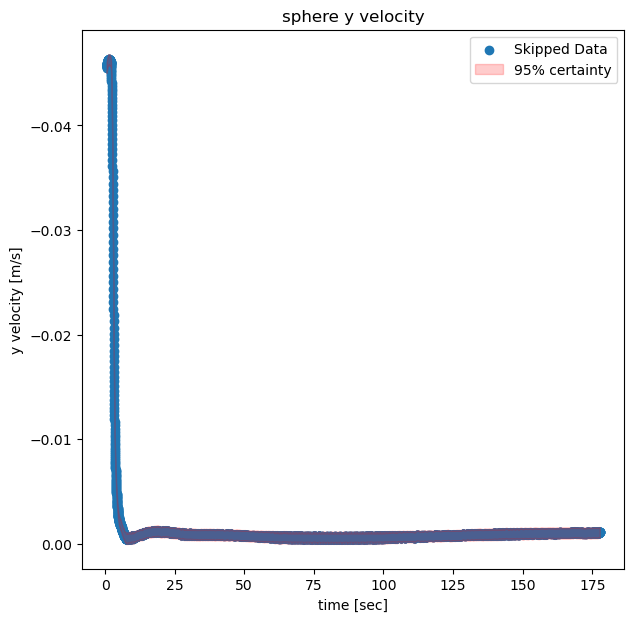

10694 10694


In [30]:
wanted_velocity_uncertainty = 0.001/2 #[m/s]
location_uncertainty_pixel = 2 #[pixel]
neighboring_points = Mf.neighboring_points_from_velocity_acceptable_error(velocity_acceptable_error = wanted_velocity_uncertainty, window_size = 0.3, dt = dt, location_uncertainty_pixel = location_uncertainty_pixel)
# y_location_meter_cutted, y_velocity_meter_cutted = Mf.calc_velocity_least_squares_lines(sphere_location_meter[:,1], dt=dt, velocity_acceptable_error = wanted_velocity_uncertainty, location_uncertainty_pixel = location_uncertainty_pixel)
# y_location_meter_cutted = Mf.location_with_respect_to_velocity(sphere_location_meter[:,1], dt=dt, velocity_acceptable_error=wanted_velocity_uncertainty, location_uncertainty_pixel = location_uncertainty_pixel)
y_location_meter_cutted, y_times_cutted, y_velocity_meter_cutted = Mf.calc_velocity_least_squares_lines_with_times(sphere_location_meter[:,1], dt=dt, neighboring_points=neighboring_points)
postivie_vel = -y_velocity_meter_cutted

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('sphere y velocity')
plt.scatter(y_times_cutted, y_velocity_meter_cutted, label='Skipped Data')
plt.fill_between(y_times_cutted, y_velocity_meter_cutted + wanted_velocity_uncertainty, y_velocity_meter_cutted - wanted_velocity_uncertainty, color='red', alpha=0.2, label='95% certainty')
print(len(y_location_meter_cutted), len(y_location_meter_cutted))


ax.set_xlabel('time [sec]')
ax.set_ylabel('y velocity [m/s]')
plt.legend()
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()
# plt.savefig(os.path.join(save_folder, 'sphere velocity PTV.svg'), transparent=True, bbox_inches='tight')

velocitys_meter = Mf.full_list_from_interpolate_between_points(y_location_meter_cutted, y_velocity_meter_cutted, sphere_location_meter[:,1])
print(len(velocitys_meter), len(sphere_location_meter[:,1]))

Acceleration

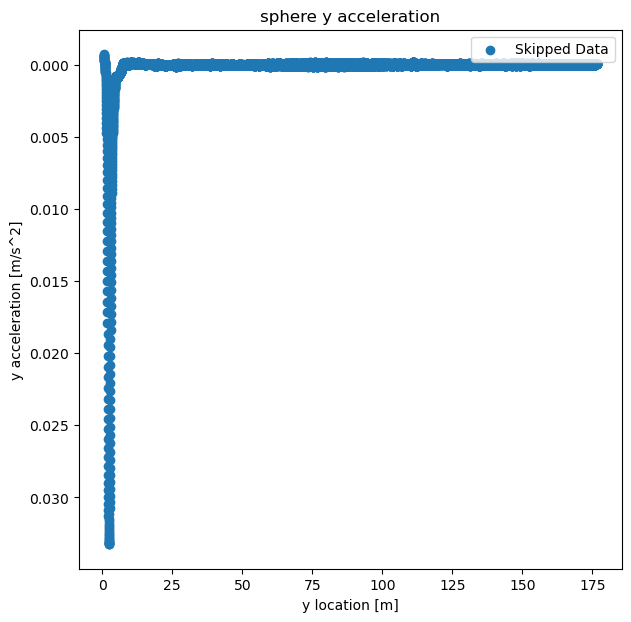

In [31]:
y_location_acccel_cutted, y_times_acccel_cutted, y_accel_meter_cutted = Mf.calc_acceleration_least_squares_lines_with_times(y_location_meter_cutted, y_velocity_meter_cutted, dt=dt, neighboring_points = neighboring_points)
y_accel_meter_cutted = np.array(y_accel_meter_cutted)


fig, ax = plt.subplots(figsize=(7, 7))
plt.title('sphere y acceleration')
plt.scatter(y_times_acccel_cutted, y_accel_meter_cutted, label='Skipped Data')


ax.set_xlabel('y location [m]')
ax.set_ylabel('y acceleration [m/s^2]')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

Load Data from excel

In [32]:
row_number = experiment_number - 1
experiment_date = Mf.read_data_from_cihx(pic_folder, '<date>')
upper_viscosity, lower_viscosity, upper_density, lower_density, Interface_thickness, sphere_diameter, sphere_rho, sphere_type, Interface_center \
      = Mf.load_data_for_demintionless_number(experiment_date = experiment_date, row_number=row_number)

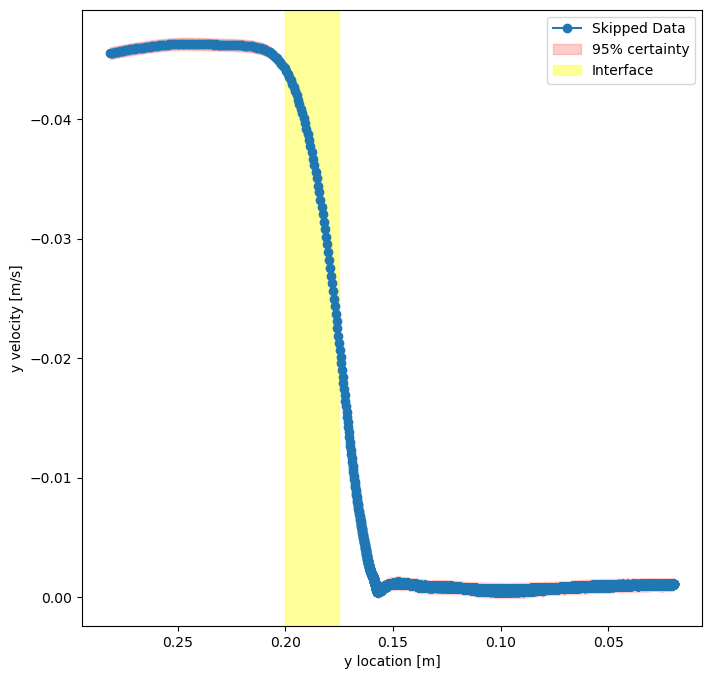

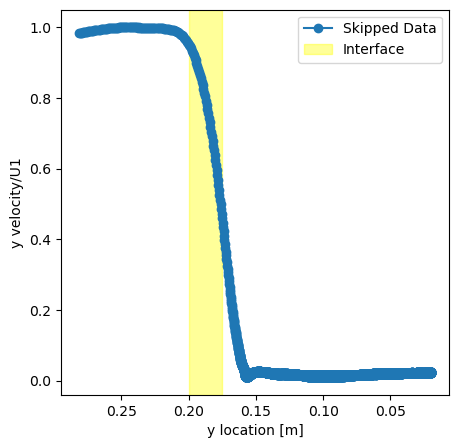

In [33]:
import matplotlib.patches as patches

# velocitys_meter = y_velocity_meter_cutted

fig, ax = plt.subplots(figsize=(8,8))
plt.plot(y_location_meter_cutted, y_velocity_meter_cutted, 'o-', label='Skipped Data')
plt.fill_between(y_location_meter_cutted, y_velocity_meter_cutted + wanted_velocity_uncertainty, y_velocity_meter_cutted - wanted_velocity_uncertainty, color='red', alpha=0.2, label='95% certainty')



# Interface
rect_x = Interface_center-Interface_thickness/2 #[m]
rect_width = Interface_thickness
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)


ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity [m/s]')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(y_location_meter_cutted, -y_velocity_meter_cutted/max(postivie_vel), 'o-', label='Skipped Data')


# Interface
rect_x = Interface_center-Interface_thickness/2 #[m]
rect_width = Interface_thickness
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)


ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity/U1')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

display the sphere with its location

In [34]:
Mf.display_images_with_points_napari(pic_folder, sphere_location_pixel, title = 'Verify sphere location')

10693

In [35]:
from scipy.constants import g
upper_velocity = -min(y_velocity_meter_cutted)
lower_velocity = -y_velocity_meter_cutted[-1]
min_velocity = -max(y_velocity_meter_cutted)

upper_Re = upper_velocity*sphere_diameter/upper_viscosity
lower_Re = lower_velocity*sphere_diameter/lower_viscosity
Brunt_number = np.sqrt(2*g/Interface_thickness*(lower_density-upper_density)/(lower_density+upper_density))
upper_Fr = upper_velocity/(Brunt_number*sphere_diameter)
lower_Fr = lower_velocity/(Brunt_number*sphere_diameter)

choosing the state.

taking 10 precent clearance

In [36]:
postivie_vel = -y_velocity_meter_cutted
if min(postivie_vel) < 0:
    state = 'bouncing'
else:
    if min(postivie_vel)*1.1 <= postivie_vel[-1]:
        state = 'minimum'
    else:
        state = 'no - minimum'
print(f'does "{state}" make sense?')

does "minimum" make sense?


New minimum

In [37]:
postivie_vel = -y_velocity_meter_cutted
if postivie_vel[-1] - wanted_velocity_uncertainty - min(postivie_vel) + wanted_velocity_uncertainty <= wanted_velocity_uncertainty:
    print ('Uncertainty Zone')

if min(postivie_vel)<0:
    state = 'bouncing'
elif postivie_vel[-1] - wanted_velocity_uncertainty > min(postivie_vel) + wanted_velocity_uncertainty:
    state = 'minimum'
else:
    state = 'no - minimum'


In [38]:
run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
calculated_sphere_rho = Mf.find_sphere_rho(sphere_diameter, upper_viscosity, upper_density, upper_velocity)
print(f'''experiment_date = {experiment_date}
Experiment Number {experiment_number}
run_number = {run_number}
sphere_type = {sphere_type}
sphere_diameter = {sphere_diameter}
sphere_rho = {sphere_rho}
upper_density = {upper_density}
lower_density = {lower_density}
upper_viscosity = {upper_viscosity}
lower_viscosity = {lower_viscosity}
calculated sphere density = {calculated_sphere_rho}
upper_Re = {upper_Re}
lower_Re = {lower_Re}
upper_Fr = {upper_Fr}
lower_Fr = {lower_Fr}
Brunt_number = {Brunt_number}
state = {state}''')

experiment_date = 2023/12/26
Experiment Number 1
run_number = 4
sphere_type = P1
sphere_diameter = 0.009545999999999999
sphere_rho = 1134
upper_density = 1113.8
lower_density = 1127.9
upper_viscosity = 1.6807999999999996e-06
lower_viscosity = 1.9008000000000003e-06
calculated sphere density = 1129.8685372181073
upper_Re = 263.0012145338298
lower_Re = 5.404151909722182
upper_Fr = 2.1837594214880003
lower_Fr = 0.05074520017325596
Brunt_number = 2.2213967989160386
state = no-minimum


# Save
y axis is positive upwards.

+ sphere_location_meter - the sphere aboslute location in meters [m] relative to bottom left corner, the origin.
+ velocitys_meter - sphere velocity in [m/s] SI units


In [39]:
print(f'In {datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")}')
file_path = os.path.join(save_folder, 'data_from_PTV.pkl')
# Mf.save_pickle(file_path, [sphere_location_meter, velocitys_meter])
Mf.save_pickle(file_path, [y_location_meter_cutted, y_times_cutted, y_velocity_meter_cutted])

file_path_accel = os.path.join(save_folder, 'accelaration_from_PTV.pkl')
Mf.save_pickle(file_path_accel, [y_location_acccel_cutted, y_times_acccel_cutted, y_accel_meter_cutted])

dimensionless_numbers_path = os.path.join(save_folder, 'dimensionless_numbers_PTV.pkl')
Mf.save_pickle(dimensionless_numbers_path, [upper_Re, lower_Re, upper_Fr, lower_Fr, Brunt_number, state])

In 2024/02/20 14:45:32
The file "data_from_PTV.pkl" has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output
The file "accelaration_from_PTV.pkl" has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output
The file "dimensionless_numbers_PTV.pkl" has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output


## save in excel

In [40]:
run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
# dimensionless_numbers_path_excel = os.path.join(parent_folder, 'Dimensionless Numbers PTV.xlsx')
dimensionless_numbers_path_excel = r'C:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Shared Folder\Excel Files\Dimensionless Numbers PTV.xlsx'


xls = pd.ExcelFile(dimensionless_numbers_path_excel)
selected_sheet_name = xls.sheet_names[0]
df = pd.read_excel(dimensionless_numbers_path_excel, sheet_name=selected_sheet_name)

new_data = {'Data Processing Date': datetime.date.today().strftime("%Y/%m/%d"), 'Data Processing Hour': datetime.datetime.now().strftime("%H:%M:%S"),
            'Experiment Date': experiment_date, 'Record number': run_number, 'Sphere Type': sphere_type, 'Experiment number': experiment_number,
            'Sphere Diameter [m]': sphere_diameter, 'Sphere density [kg/m^3]': sphere_rho, 'Upper density [kg/m^3]': upper_density,
            'Lower density [kg/m^3]': lower_density, 'Upper viscosity [m^2/sec]': upper_viscosity, 'Lower viscosity [m^2/sec]': lower_viscosity,
            'Upper velocity [m/s]': upper_velocity, 'Lower velocity [m/s]': lower_velocity,'Minimum velocity [m/s]': min_velocity,
            'Upper Re': upper_Re, 'Lower Re': lower_Re, 'Upper Fr': upper_Fr, 'Lower Fr': lower_Fr, 'Brunt Number': Brunt_number, 'State': state,
            'Calculated sphere density [kg/m^3]': calculated_sphere_rho, 'Interface width [m]': Interface_thickness,
            'Full Trajectory Time [sec]': len(Mf.find_pictures(pic_folder))/frames_per_second, 'Index': len(df),
            'Vertical Location For Velocity [m] list':np.array(y_location_meter_cutted).tolist(),
            'Velocity Times [sec] list' : np.array(y_times_cutted).tolist(),
            'Velocity [m/s] list': np.array(y_velocity_meter_cutted).tolist(),
            'Solution': 'Water - Salt',
            'First Frame': t_0_frame, 'Frames Per Second': frames_per_second, 'Scaling Factor': scaling_factor, 'Note' : 'Manually'}

df.loc[len(df)] = new_data
df.to_excel(dimensionless_numbers_path_excel, sheet_name=selected_sheet_name, index=False)
xls.close()

print(f'The file {os.path.basename(dimensionless_numbers_path_excel)} has been updated at: {os.path.dirname(dimensionless_numbers_path_excel)}')

The file Dimensionless Numbers PTV.xlsx has been updated at: C:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Shared Folder\Excel Files


load from excel and plot

In [41]:
if False:
    loaded_df_from_excel = pd.read_excel(dimensionless_numbers_path_excel)

    # Convert the DataFrame columns back to numpy arrays
    y_times_cutted1 =   np.array(eval(loaded_df_from_excel['Velocity Times [sec] list'][len(loaded_df_from_excel)-1]))
    y_loc_cutted1 = np.array(eval(loaded_df_from_excel['Vertical Location For Velocity [m] list'][len(loaded_df_from_excel)-1]))
    y_velocity_meter_cutted1 = np.array(eval(loaded_df_from_excel['Velocity [m/s] list'][len(loaded_df_from_excel)-1]))

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.title('sphere y velocity')
    plt.scatter(y_times_cutted1, y_velocity_meter_cutted1, label='Skipped Data')


    ax.set_xlabel('time [sec]')
    ax.set_ylabel('y velocity [m/s]')
    plt.legend()
    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

In [42]:
new_pickle_data = new_data.copy()
new_column = np.arange(t_0_frame, t_0_frame + len(sphere_location_meter))
sphere_location_meter_with_frame = np.hstack((new_column.reshape(-1, 1), sphere_location_meter))
sphere_location_pixel_with_frame = np.hstack((new_column.reshape(-1, 1), sphere_location_pixel))

new_pickle_data['Sphere Locations'] = sphere_location_meter_with_frame
new_pickle_data['Sphere Locations Pixel'] = sphere_location_pixel_with_frame

update the pickle dictionary

the key is the date + run number, and the vlaue is "new_data"

In [43]:
pickle_location = r'C:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Shared Folder\Excel Files\The Big Pickle.pkl'
The_big_pickle = Mf.load_pickle(pickle_location)

The_big_pickle[f'Experiment Date {experiment_date} Experiment Number {experiment_number} Record Number {run_number}'] = new_pickle_data
Mf.save_pickle(pickle_location, The_big_pickle)

The file "The Big Pickle.pkl" has been saved at: C:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Shared Folder\Excel Files


DO NOT USE

In [44]:
# from pprint import pprint
# new_sphere_location = []
# for i in range(len(sphere_location)):
#     new_sphere_location.append(Mf.enhance_coordinates(Mf.find_pictures(pic_folder, True)[i], sphere_location[i], bias = 36))
#     pprint((sphere_location[i][1], new_sphere_location[i][1]))